In [5]:
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import skimage as ski
import holopy as hp
import cv2
def loadFestoLog(FFESTO):
    opt = {
        "delimiter" : ";",
        "names" : ["DATE", "X", "Y", "Z"]
    }
    festoLog = pd.read_csv(FFESTO, **opt)
    festoLog.DATE = pd.to_datetime(festoLog.DATE,  unit="ms")

    festoLog.X = festoLog.X/1000
    festoLog.Y = festoLog.Y/1000
    festoLog.Z = festoLog.Z/1000
    
    DATE = festoLog
    return DATE

def loadPlutoLog(FPLUTO):
    opt = {
        "delimiter" : " ",
        "names" : ["DATE", "FREQUENCY_TX", "FREQUENCY_RX", "MOD_I", "PHASE_I", "MOD_Q", "PHASE_Q", "MOD", "PHASE"],
        "dtype" : {'FREQUENCY_TX': float, 'FREQUENCY_RX': float, 'MOD_I': float, 
                   'PHASE_I': float, 'MOD_Q': float, 'PHASE_Q': float, 'MOD': float, 'PHASE': float},
        "parse_dates": ["DATE"],
        "date_parser": lambda x: pd.to_datetime(x, format="%Y/%m/%d-%H:%M:%S.%f"),
        "skipinitialspace": True,
        "skiprows": 1
    }

    plutoScan = pd.read_csv(FPLUTO, **opt)
    DATE = plutoScan
    return DATE

In [6]:
def fill_zeros_discretized_enhanced(data):
    rows, cols = data.shape

    # Sostituisce gli zeri nelle prime colonne
    for i in range(rows):
        non_zero_indices = np.nonzero(data[i, :])[0]
        if non_zero_indices.size > 0:
            first_non_zero = data[i, non_zero_indices[0]]
            data[i, :non_zero_indices[0]] = first_non_zero

    # Sostituisce gli zeri nelle prime righe
    for j in range(cols):
        non_zero_indices = np.nonzero(data[:, j])[0]
        if non_zero_indices.size > 0:
            for zero_idx in np.where(data[:non_zero_indices[0], j] == 0)[0]:
                if zero_idx < (0.05 * rows):
                    data[zero_idx, j] = data[non_zero_indices[0], j]
    return data

In [7]:
def zero_normalization(array):
    rows, columns = array.shape
    for i in range(rows):
        for j in range(columns):
            if array[i, j] == 0:
                for jj in range(columns):
                    if array[i,j] != 0:
                        break
                    if array[i, jj] != 0:
                        array[i, j] = array[i, jj]
    return array

In [13]:
def unifyLog(festo_file_path, pluto_file_path):

    # definisco costanti
    NEIG = "none"
    INTM = "natural"
    TOFF = 0
    P1 = loadFestoLog(festo_file_path)
    co, ce = np.histogram(P1.Z, 1000)
    cx = np.argmax(co)
    H = ce[cx]*1000
    P2 = loadPlutoLog(pluto_file_path)
    P2.DATE = P2.DATE + pd.to_timedelta(TOFF * 1e-3, unit='s') #TOFF inutile dato che mantiene valore 0 per tutto il programma
    #verifico saturazione segnali
    if any((abs(P2.MOD_I * np.sin(P2.PHASE_I)) >= 2**11-1) | (abs(P2.MOD_I * np.cos(P2.PHASE_I)) >= 2**11-1)): 
        print('WARNING: signal I is saturated.')
    if any((abs(P2.MOD_Q * np.sin(P2.PHASE_Q)) >= 2**11-1)| (abs(P2.MOD_Q * np.cos(P2.PHASE_Q)) >= 2**11-1)):
        print('WARNING: signal Q is saturated.')
    #Index of PLUTO's data within FESTO's time window
    P_ix = np.where((P2.DATE >= min(P1.DATE)) & (P2.DATE <= max(P1.DATE)))
    P_F = P2.FREQUENCY_TX[P_ix[0]] #P_ix it's a list of arrays
    P_F_UNIQUE = np.unique(P_F)
    P_F_UNIQUE = np.sort(P_F_UNIQUE)
    #P_DATE = np.empty(len(P_ix[0]), dtype="datetime64[ns]")
    P_DATE = P2.DATE[P_ix[0]]
    P_MOD = P2.MOD[P_ix[0]]
    P_PHASE = P2.PHASE[P_ix[0]]
    F_X = P1.X
    F_Y = P1.Y
    F_DATE = P1.DATE

    
    FFMOD = []
    FFPHASE = []
    P_X = []
    P_Y = []
    for n in range(0, len(P_F_UNIQUE)):
        P_X.append(np.interp(P_DATE, F_DATE,  F_X, left=np.nan, right=np.nan))
        P_Y.append(np.interp(P_DATE, F_DATE,  F_Y, left=np.nan, right=np.nan))
    px = np.array(P_X[0])
    py = np.array(P_Y[0])
    
    from scipy.interpolate import griddata

    # Definizione della griglia regolare
    xi = np.linspace(min(px), max(px), 6098)
    yi = np.linspace(max(py), min(py), 5948)



    # Interpolazione dei dati sparsi sulla griglia regolare
    FFMOD = griddata((px, py), P_MOD.values, (xi[None, :], yi[:, None]), method = "linear")
    FFPHASE = griddata((px, py), P_PHASE.values, (xi[None, :], yi[:, None]), method = "linear")
    
    FFMOD = FFMOD[:-200,350:] 
    FFPHASE = FFPHASE[:-200,350:] #taglio le righe e colonne con gli elementi pari a 0

    # zi conterrà i valori interpolati sulla griglia regolare
    FFMOD[np.isnan(FFMOD)] = 0
    FFPHASE[np.isnan(FFPHASE)] = 0
    
    fourier_transform = FFMOD * np.exp(1j * FFPHASE)
    fourier_transform = np.abs(fourier_transform)
    fourier_transform = fill_zeros_discretized_enhanced(fourier_transform)
    fourier_transform = zero_normalization(fourier_transform)
    
    return fourier_transform, px, py

In [9]:
def unifyLog2(festo_file_path, pluto_file_path):

    # definisco costanti
    NEIG = "none"
    INTM = "natural"
    TOFF = 0
    P1 = loadFestoLog(festo_file_path)
    co, ce = np.histogram(P1.Z, 1000)
    cx = np.argmax(co)
    H = ce[cx]*1000
    P2 = loadPlutoLog(pluto_file_path)
    P2.DATE = P2.DATE + pd.to_timedelta(TOFF * 1e-3, unit='s') #TOFF inutile dato che mantiene valore 0 per tutto il programma
    #verifico saturazione segnali
    if any((abs(P2.MOD_I * np.sin(P2.PHASE_I)) >= 2**11-1) | (abs(P2.MOD_I * np.cos(P2.PHASE_I)) >= 2**11-1)): 
        print('WARNING: signal I is saturated.')
    if any((abs(P2.MOD_Q * np.sin(P2.PHASE_Q)) >= 2**11-1)| (abs(P2.MOD_Q * np.cos(P2.PHASE_Q)) >= 2**11-1)):
        print('WARNING: signal Q is saturated.')
    #Index of PLUTO's data within FESTO's time window
    P_ix = np.where((P2.DATE >= min(P1.DATE)) & (P2.DATE <= max(P1.DATE)))
    P_F = P2.FREQUENCY_TX[P_ix[0]] #P_ix it's a list of arrays
    P_F_UNIQUE = np.unique(P_F)
    P_F_UNIQUE = np.sort(P_F_UNIQUE)
    #P_DATE = np.empty(len(P_ix[0]), dtype="datetime64[ns]")
    P_DATE = P2.DATE[P_ix[0]]
    P_MOD = P2.MOD[P_ix[0]]
    P_PHASE = P2.PHASE[P_ix[0]]
    F_X = P1.X
    F_Y = P1.Y
    F_DATE = P1.DATE
    FFMOD = []
    FFPHASE = []
    P_X = []
    P_Y = []
    for n in range(0, len(P_F_UNIQUE)):
        P_X.append(np.interp(P_DATE, F_DATE,  F_X, left=np.nan, right=np.nan))
        P_Y.append(np.interp(P_DATE, F_DATE,  F_Y, left=np.nan, right=np.nan))
    px = np.array(P_X[0])
    py = np.array(P_Y[0])
    
    from scipy.interpolate import griddata

    # Definizione della griglia regolare
    xi = np.linspace(min(px), max(px), 6298)
    yi = np.linspace(max(py), min(py), 6298)

    # Interpolazione dei dati sparsi sulla griglia regolare
    FFMOD = griddata((px, py), P_MOD.values, (xi[None, :], yi[:, None]), method = "linear")
    FFPHASE = griddata((px, py), P_PHASE.values, (xi[None, :], yi[:, None]), method = "linear")

    # zi conterrà i valori interpolati sulla griglia regolare
    FFMOD[np.isnan(FFMOD)] = 0
    FFPHASE[np.isnan(FFPHASE)] = 0
    
    fourier_transform = FFMOD * np.exp(-1j * FFPHASE)
    fourier_transform = np.abs(fourier_transform)
    fourier_transform = fill_zeros_discretized_enhanced(fourier_transform)
    fourier_transform = zero_normalization(fourier_transform)
    
    return fourier_transform, px, py

In [15]:
fourier_mine, px, py = unifyLog('/home/lbisognin/Asmara/Data/IN_SCAN/TraceData_0229_4_A.csv', '/home/lbisognin/Asmara/Data/IN_SCAN/plutoScan_0229_4_A.log')
print("test 1")
fourier_soil, px, py = unifyLog('/home/lbisognin/Asmara/Data/NEW_SCANS_2/TraceData_0222_T72_0_wo2.csv', '/home/lbisognin/Asmara/Data/NEW_SCANS_2/plutoScan_0222_T72_0_wo2.log')
print("test 2")
fourier_full, px, py = unifyLog('/home/lbisognin/Asmara/Data/NEW_SCANS_2/TraceData_0220_T72_0.csv', '/home/lbisognin/Asmara/Data/NEW_SCANS_2/plutoScan_0220_T72_0.log')

/tmp/ipykernel_40301/2792575805.py:35: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  plutoScan = pd.read_csv(FPLUTO, **opt)


test 1


/tmp/ipykernel_40301/2792575805.py:35: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  plutoScan = pd.read_csv(FPLUTO, **opt)


test 2


/tmp/ipykernel_40301/2792575805.py:35: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  plutoScan = pd.read_csv(FPLUTO, **opt)


In [21]:
#BIANCO: VALORI ALTI, NERO: VALORI BASSI!

In [141]:
def stampa_array_bidimensionale(array):
    for riga in array:
        for elemento in riga:
            print(elemento, end=" ")
        print()

In [33]:
#NORMALIZZAZIONE CORRETTA
min_val = fourier_mine.min()
max_val = fourier_mine.max()

min_val2 = fourier_soil.min()
max_val2 = fourier_soil.max()

min_val3 = fourier_full.min()
max_val3 = fourier_full.max()

max_value = max(max_val, max_val2, max_val3)
min_value = min(min_val, min_val2, min_val3)

normalized_inverted_mine =  ((fourier_mine - min_value) / (max_value - min_value))

normalized_mine = ((fourier_mine - min_value) / (max_value - min_value)) # ai fini del controllo

#normalized_inverted_mine[normalized_inverted_mine > 0.40] = 0.85

normalized_array_soil = ((fourier_soil - min_value) / (max_value - min_value))

px2 = px
py2 = py

alpha = 0.3
synthetic_image = ((alpha) * normalized_inverted_mine + (1-alpha) * normalized_array_soil)

natural_image = ((fourier_full - min_value) / (max_value - min_value))

In [36]:
downsampled_mine = normalized_inverted_mine[::40, ::40]

In [ ]:
for riga in downsampled_mine:
    for elemento in riga:
        print(elemento, end=" ")
    print()

In [34]:
synthetic_image, natural_image

(array([[0.56493079, 0.56493079, 0.56493079, ..., 0.49830508, 0.54660012,
         0.56493079],
        [0.56493079, 0.56493079, 0.56493079, ..., 0.49830508, 0.54660012,
         0.56493079],
        [0.62284297, 0.62284297, 0.62284297, ..., 0.49830508, 0.54660012,
         0.62284297],
        ...,
        [0.65486755, 0.65485077, 0.654834  , ..., 0.65486755, 0.65486755,
         0.65486755],
        [0.65486976, 0.65485299, 0.65483621, ..., 0.65486976, 0.65486976,
         0.65486976],
        [0.65487197, 0.6548552 , 0.65483842, ..., 0.65487197, 0.65487197,
         0.65487197]]),
 array([[0.56868072, 0.56868072, 0.56868072, ..., 0.55662128, 0.62880838,
         0.56868072],
        [0.56868072, 0.56868072, 0.56868072, ..., 0.55662128, 0.62880838,
         0.56868072],
        [0.63662248, 0.63662248, 0.63662248, ..., 0.55662128, 0.62880838,
         0.63662248],
        ...,
        [0.69857103, 0.69857073, 0.69857042, ..., 0.69857103, 0.69857103,
         0.69857103],
        [0.6

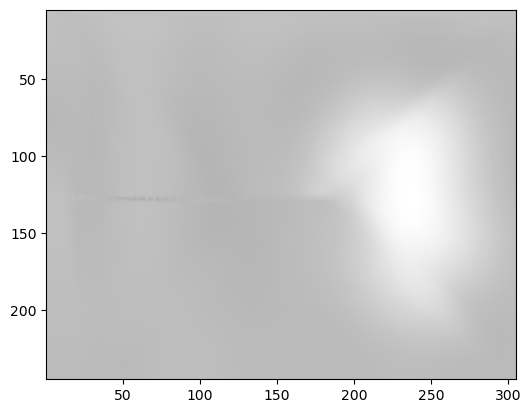

In [28]:
plt.imshow(normalized_inverted_mine, extent=(min(px), max(px), max(py), min(py)), origin='lower', cmap="gray")
plt.margins(0)
#plt.savefig('/home/lbisognin/Asmara/images/testing6.jpg', dpi=300, bbox_inches='tight', pad_inches=0)
# Aggiunge la funzione ai cursori del plot

plt.show()

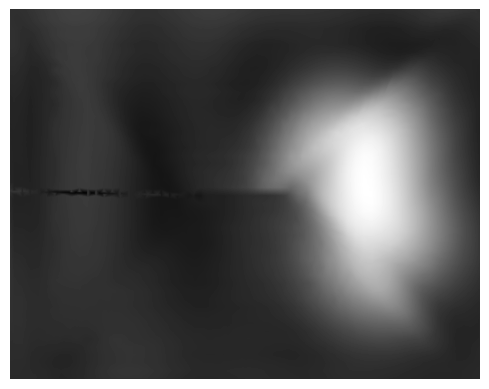

In [26]:
plt.imshow(fourier_mine, extent=(min(px), max(px), max(py), min(py)), origin='lower', cmap="gray")
plt.axis('off')
plt.margins(0)
#plt.savefig('/home/lbisognin/Asmara/images/testing6.jpg', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

In [10]:
#PER CASI IN CUI DEVO VERIFICARE CORRELAZIONE SENZA FUSIONE

#NORMALIZZAZIONE CORRETTA
min_val = fourier_mine.min()
max_val = fourier_mine.max()

min_val3 = fourier_full.min()
max_val3 = fourier_full.max()

max_value = max(max_val, max_val3)
min_value = min(min_val, min_val3)

#EFFETTUO NORMALIZZAZIONE VALORI IMMAGINE 1

synthetic_image =((fourier_mine - min_value) / (max_value - min_value))

px2 = px
py2 = py

#EFFETTUO NORMALIZZAZIONE VALORI IMMAGINE 2
natural_image =((fourier_full - min_value) / (max_value - min_value))


In [22]:
synthetic_image, natural_image

(array([[ 0.88980464,  0.88980464,  0.88980464, ...,  0.84366954,
          0.81324604,  0.88980464],
        [ 0.88980464,  0.88980464,  0.88980464, ...,  0.84366954,
          0.81324604,  0.88980464],
        [ 0.91247412,  0.91247412,  0.91247412, ...,  0.84366954,
          0.81324604,  0.91247412],
        ...,
        [ 0.97318814,  0.97318814,  0.9731661 , ...,  0.97318814,
          0.97318814,  0.97318814],
        [ 0.97318701,  0.97318701,  0.97316496, ...,  0.97318701,
          0.97318701,  0.97318701],
        [-0.07039861, -0.07039861, -0.07039861, ..., -0.07039861,
         -0.07039861, -0.07039861]]),
 array([[0.89289751, 0.89289751, 0.89289751, ..., 0.85939863, 0.84915328,
         0.89289751],
        [0.89289751, 0.89289751, 0.89289751, ..., 0.85939863, 0.84915328,
         0.89289751],
        [0.92145768, 0.92145768, 0.92145768, ..., 0.85939863, 0.84915328,
         0.92145768],
        ...,
        [0.95158923, 0.95158923, 0.95175338, ..., 0.95158923, 0.95158923

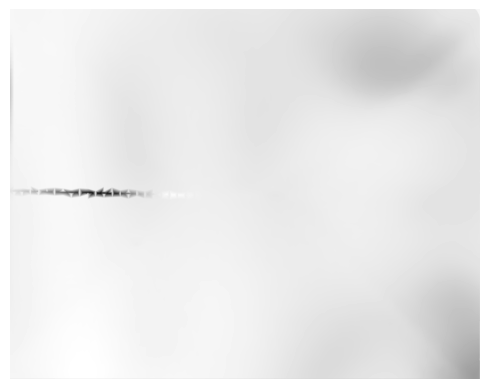

In [29]:
plt.imshow(synthetic_image, extent=(min(px2), max(px2), max(py2), min(py2)), origin='lower', cmap="gray")
plt.axis('off')
plt.margins(0)
plt.savefig('/home/lbisognin/Asmara/images_3/synthetic_image', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

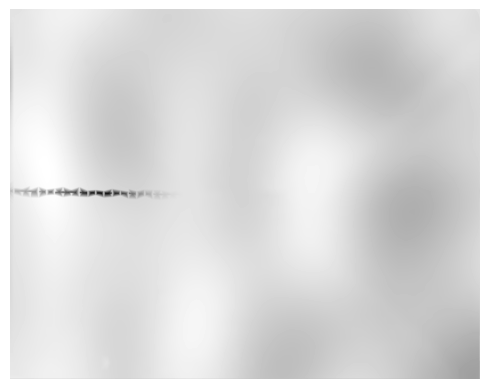

In [30]:
plt.imshow(natural_image, extent=(min(px2), max(px2), max(py2), min(py2)), origin='lower', cmap="gray")
plt.axis('off')
plt.margins(0)
plt.savefig('/home/lbisognin/Asmara/images_3/natural_image', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

In [82]:
downsampled_synthetic_image = synthetic_image[::40, ::40]
downsampled_natural_image = natural_image[::40, ::40]

from scipy.signal import convolve2d

result = convolve2d(downsampled_synthetic_image, downsampled_natural_image,  mode='full', boundary='fill', fillvalue=0)
result_max= convolve2d(downsampled_natural_image, downsampled_natural_image,  mode='full', boundary='fill', fillvalue=0)

In [57]:
def calcola_media_pesata_conv2d(result_conv,dim_immagine):    
    # Calcola i pesi basati sul grado di sovrapposizione
    dim_output = result_conv.shape
    pesos = np.zeros(dim_output)
    
    for i in range(dim_output[0]):
        for j in range(dim_output[1]):
            # Il peso è calcolato come la distanza minima dai bordi, considerando le dimensioni dell'immagine
            dist_min_i = min(i + 1, dim_output[0] - i, dim_immagine[0])
            dist_min_j = min(j + 1, dim_output[1] - j, dim_immagine[1])
            peso = min(dist_min_i, dist_min_j)
            pesos[i, j] = peso
    
    # Calcola la media pesata
    media_pesata = np.sum(result_conv * pesos) / np.sum(pesos)
    return media_pesata, pesos

In [83]:
normalized_result,pesos  = calcola_media_pesata_conv2d(result, downsampled_natural_image.shape)
normalized_result_max,pesos2 = calcola_media_pesata_conv2d(result_max, downsampled_natural_image.shape)
normalized_result, normalized_result_max, normalized_result/normalized_result_max

(5843.937538407469, 5810.225891803853, 1.0058021232274585)

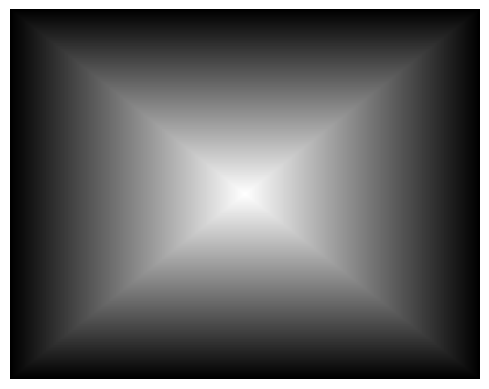

In [17]:
plt.imshow(downsampled_natural_image, extent=(min(px2), max(px2), max(py2), min(py2)), origin='lower', cmap="gray")
plt.axis('off')
plt.margins(0)
#plt.savefig('/home/lbisognin/Asmara/images/testing_full2.jpg', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

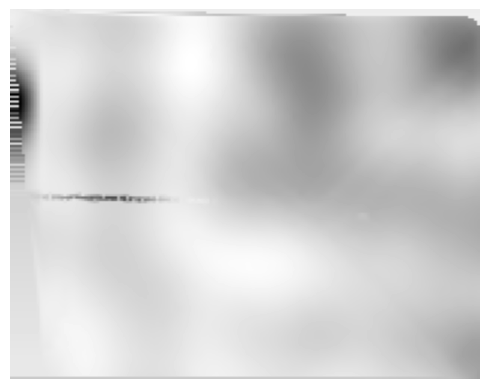

In [139]:
plt.imshow(downsampled_synthetic_image, extent=(min(px2), max(px2), max(py2), min(py2)), origin='lower', cmap="gray")
plt.axis('off')
plt.margins(0)
#plt.savefig('/home/lbisognin/Asmara/images/testing_full2.jpg', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

In [20]:
def create_inversion(img, MEDIUM_INDEX = None, WAVELENGTH = 15, SPACING = 0.5, distance = 30, zsteps = 40):
    
    assert MEDIUM_INDEX is not None, "MEDIUM_INDEX is not defined"
    
    # load image from file
    raw_holo = hp.load_image(img, 
                            medium_index=MEDIUM_INDEX, 
                            illum_wavelen=WAVELENGTH,
                            illum_polarization=(1,0), 
                            spacing=SPACING, channel=0)
                        
    zstack = np.linspace(0, distance, zsteps+1)
    rec_vol = hp.propagate(raw_holo, zstack)

    return rec_vol

In [21]:
inversion_unify = create_inversion('/home/lbisognin/Asmara/images_3/synthetic_image.png', 4)
#inversion_full = create_inversion('/home/lbisognin/Asmara/images/testing_full2.jpg', 4)

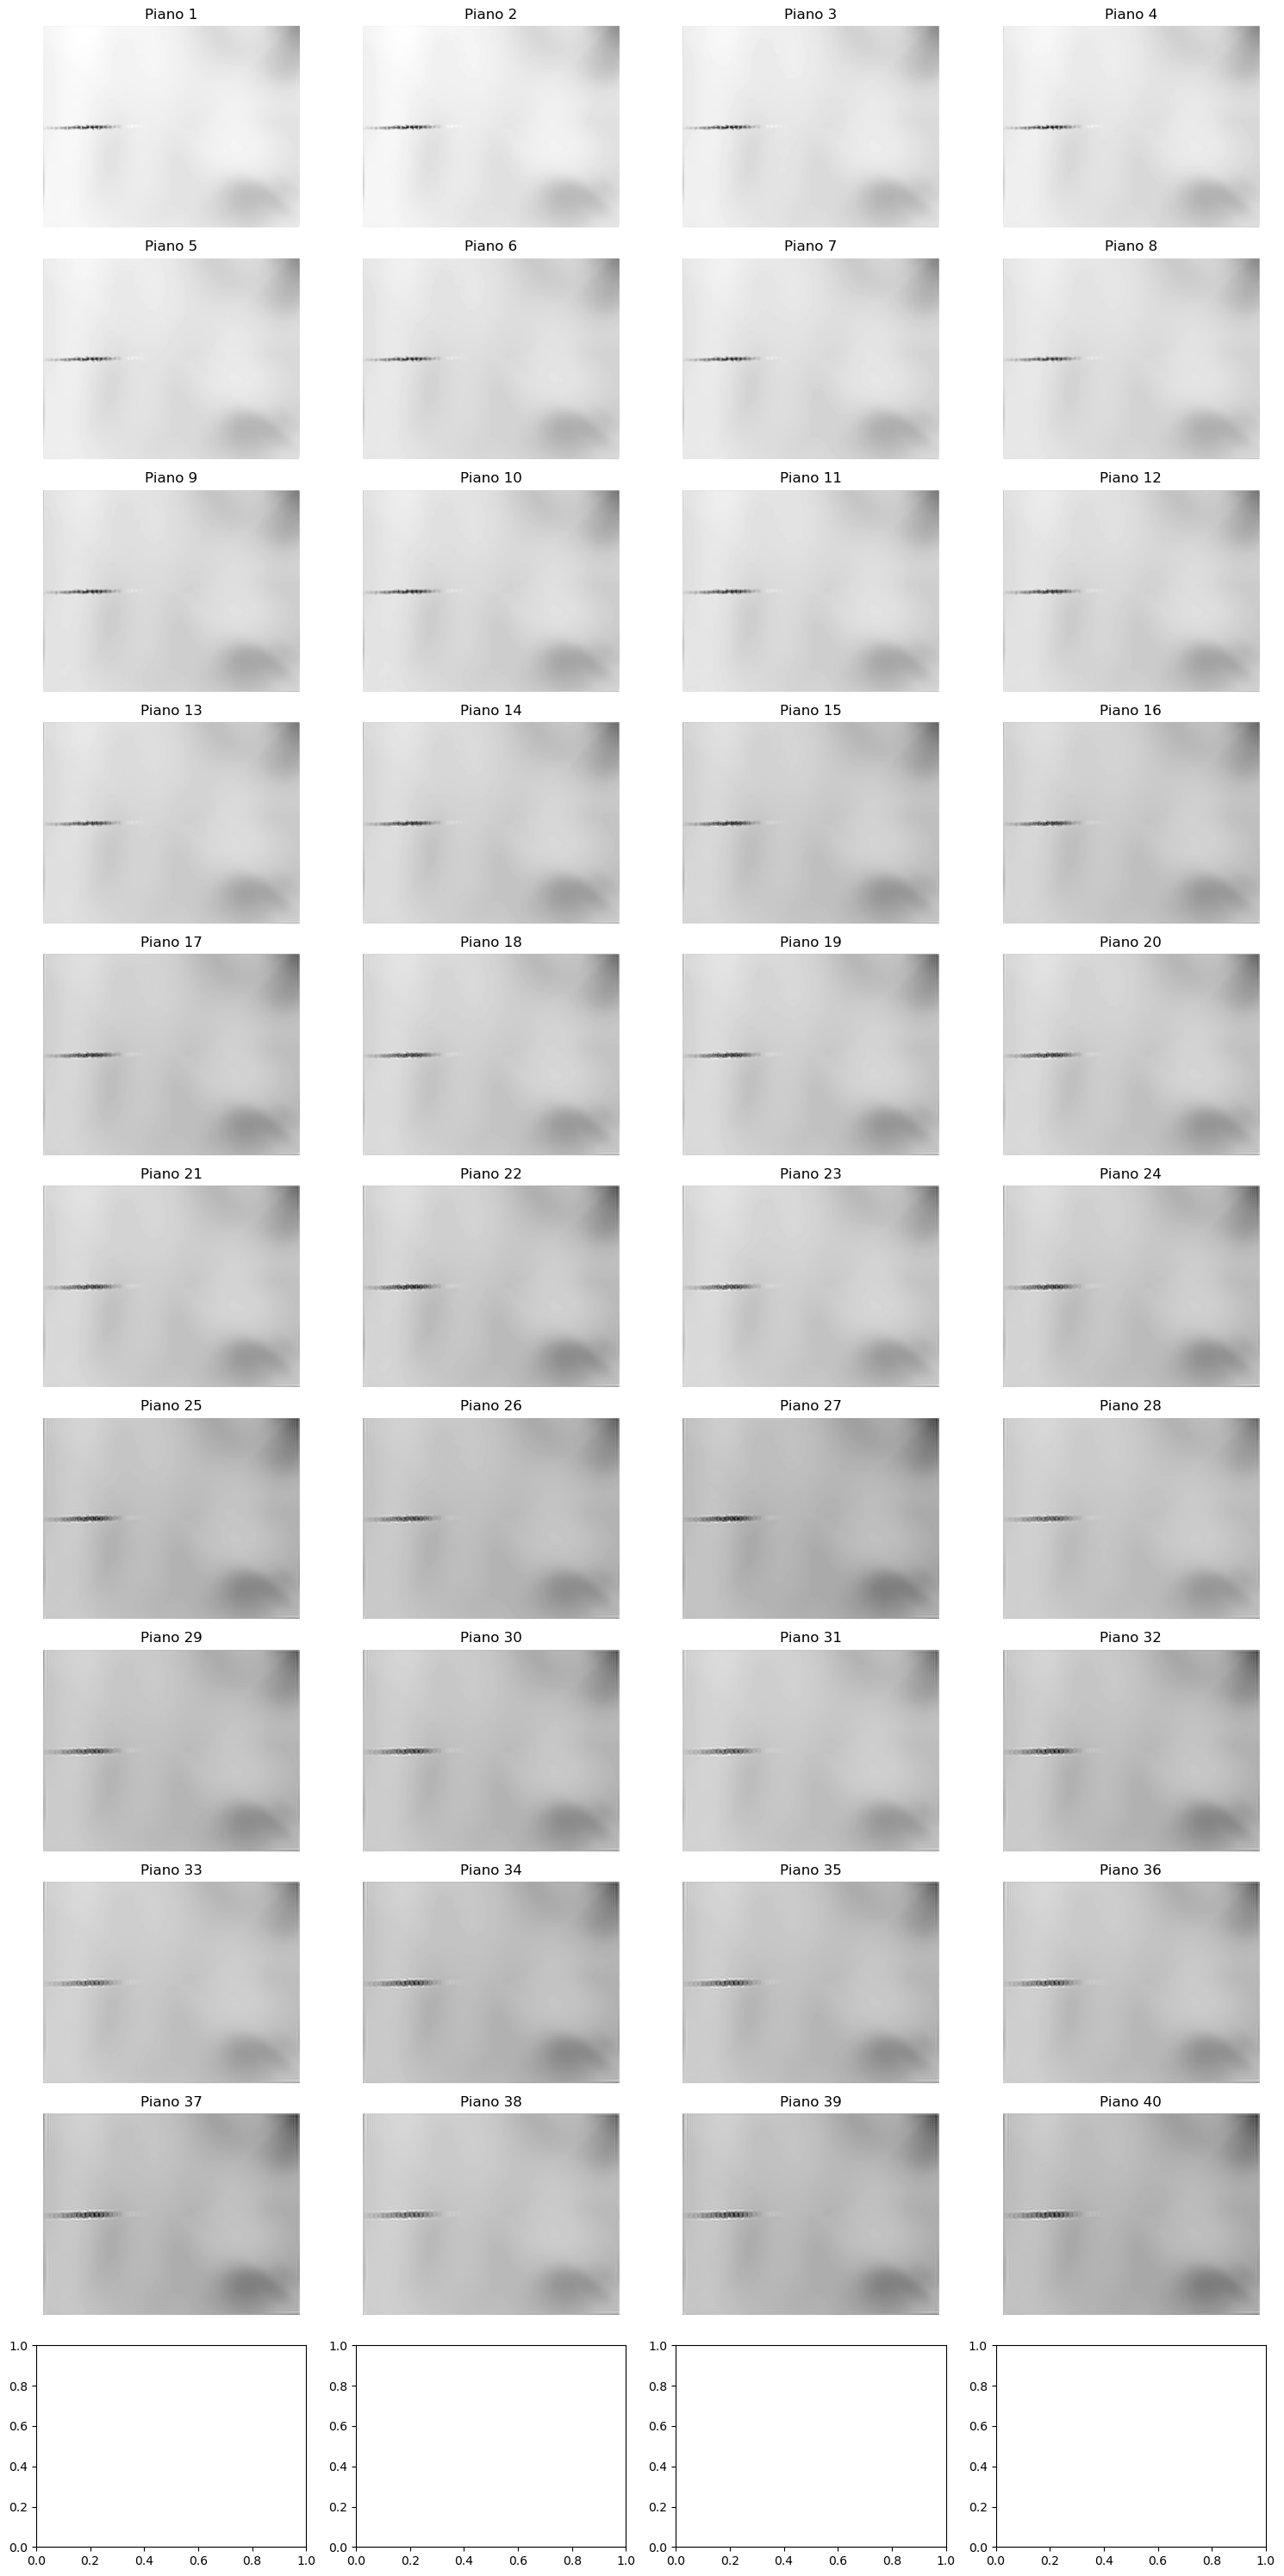

In [22]:
num_rows = 11
num_cols = 4

# Crea una nuova figura
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 30))

# Itera attraverso tutti i piani
for i in range(0, 40):
    # Calcola l'indice di riga e colonna per il piano corrente
    row_index = i // num_cols
    col_index = i % num_cols
    
    # Estrai il piano corrente
    plane = np.abs(inversion_unify[i])
    
    # Disegna il piano corrente sul subplot corrispondente
    axes[row_index, col_index].imshow(plane, origin='lower', cmap='gray')
    
    # Imposta i titoli delle colonne
    axes[row_index, col_index].set_title(f'Piano {i + 1}')
    
    # Nascondi le etichette degli assi per una migliore visualizzazione
    axes[row_index, col_index].axis('off')

# Aggiusta il layout per evitare sovrapposizioni
plt.tight_layout()
plt.show()

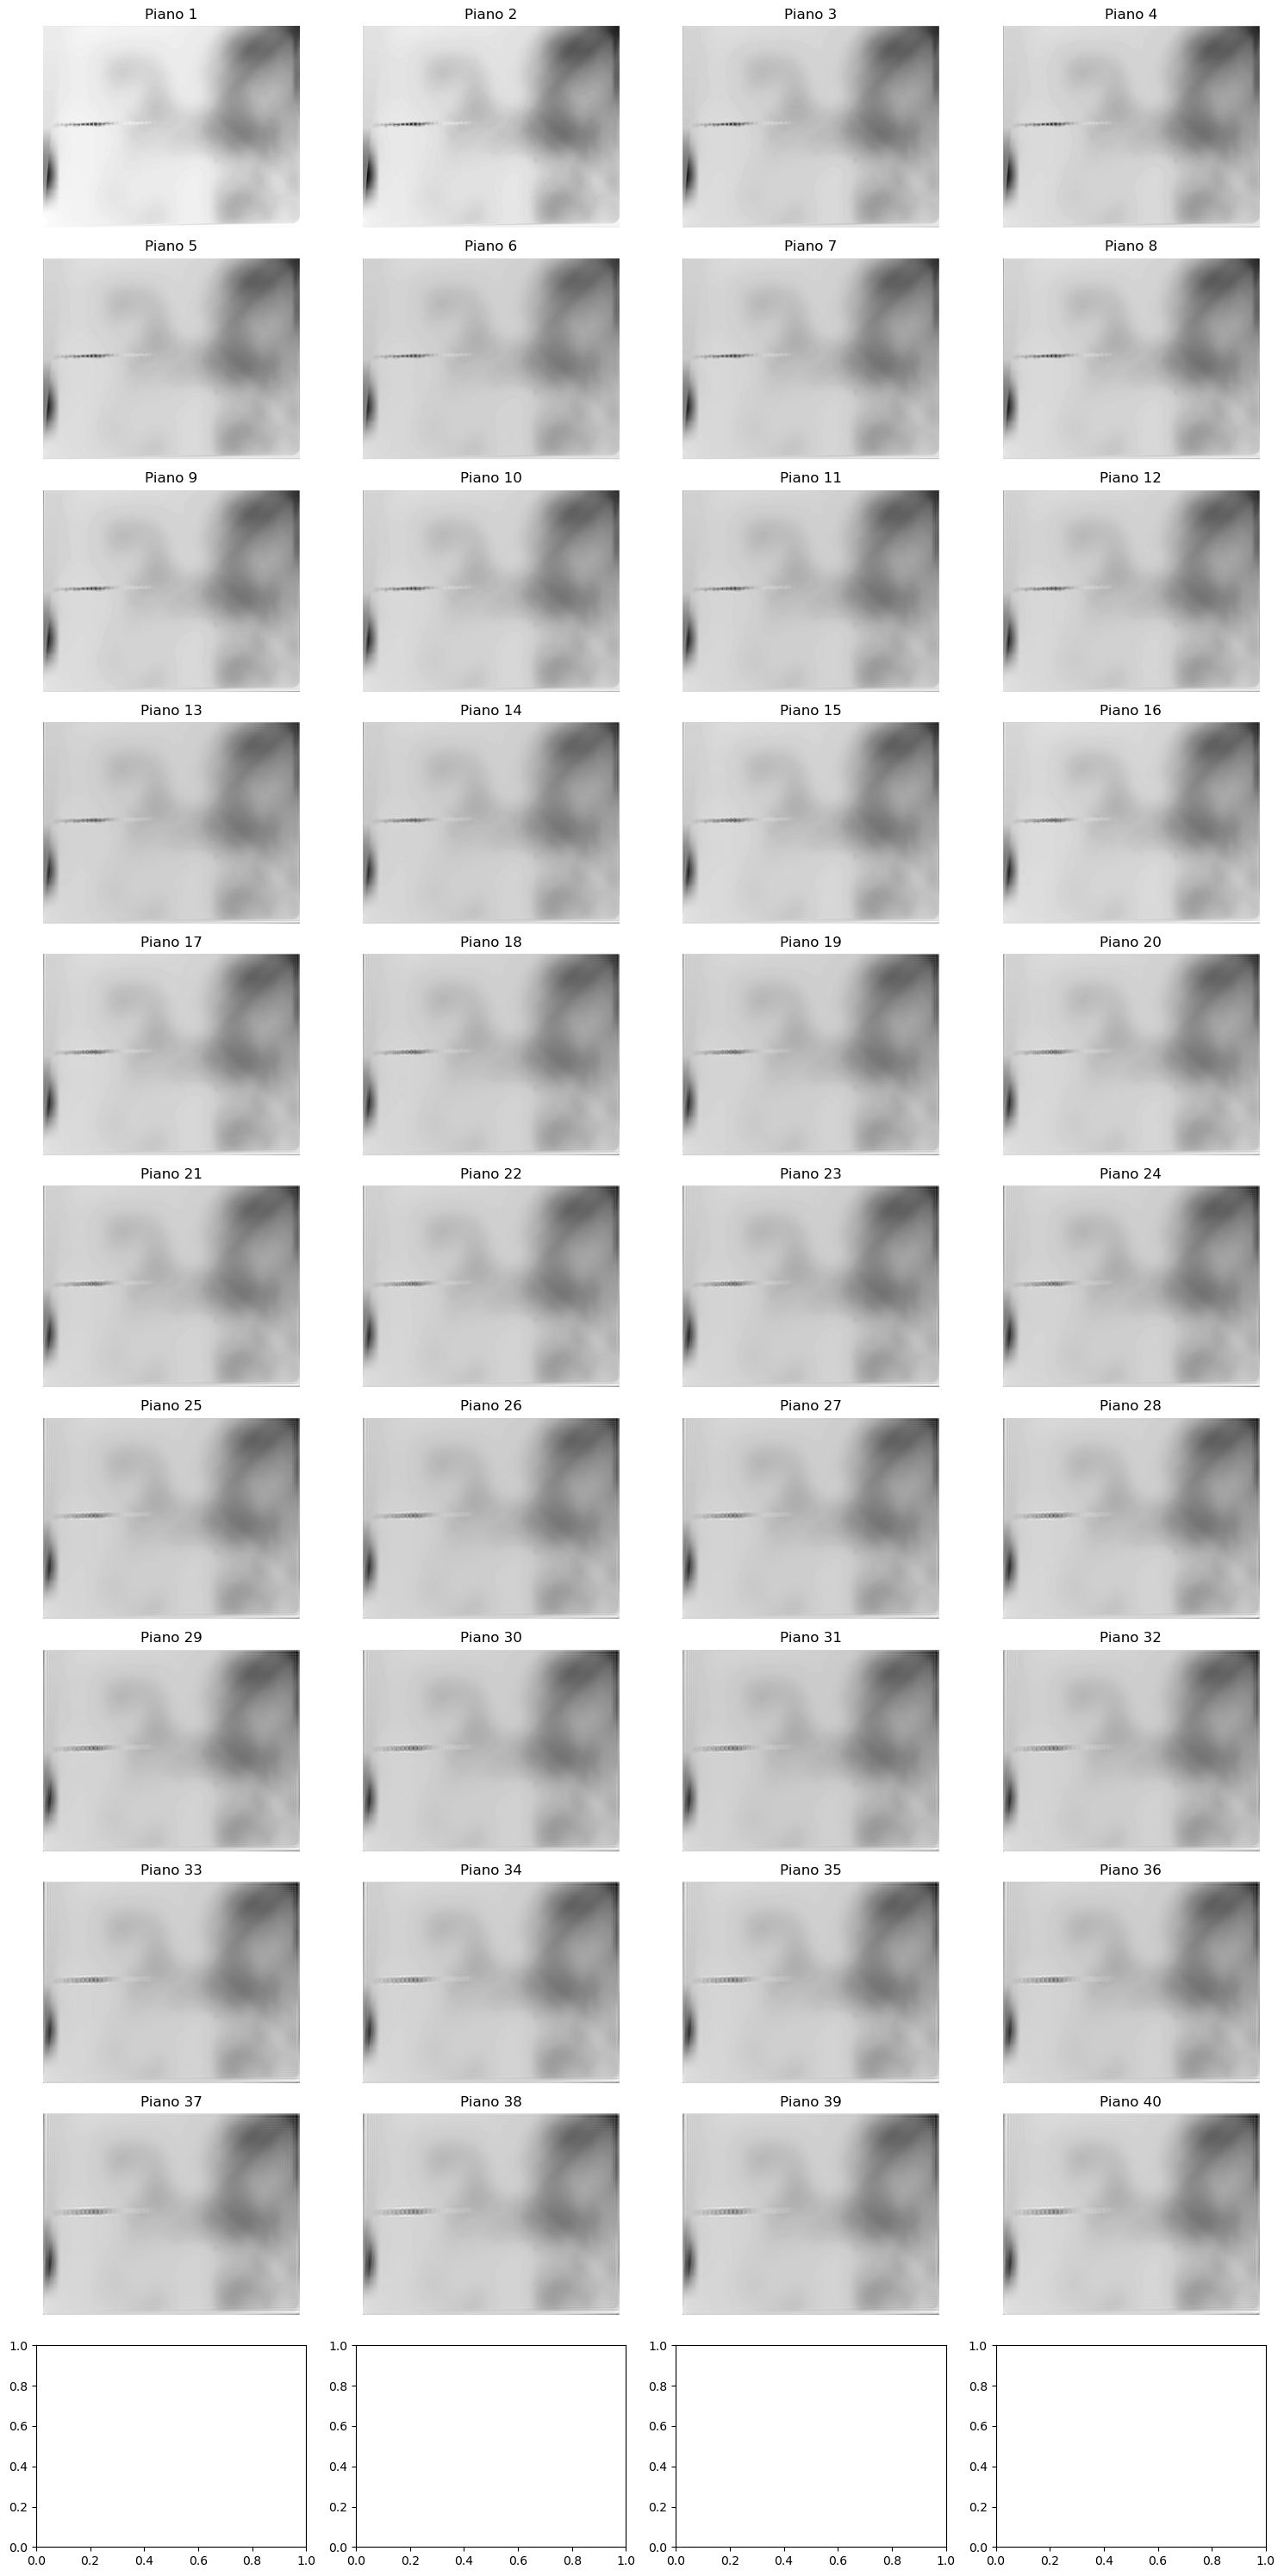

In [114]:
num_rows = 11
num_cols = 4

# Crea una nuova figura
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 30))

# Itera attraverso tutti i piani
for i in range(0, 40):
    # Calcola l'indice di riga e colonna per il piano corrente
    row_index = i // num_cols
    col_index = i % num_cols
    
    # Estrai il piano corrente
    plane = np.abs(inversion_full[i])
    
    # Disegna il piano corrente sul subplot corrispondente
    px = (plane).x
    py = (plane).y
    axes[row_index, col_index].imshow(plane, origin='lower', cmap='gray')
    
    # Imposta i titoli delle colonne
    axes[row_index, col_index].set_title(f'Piano {i + 1}')
    
    # Nascondi le etichette degli assi per una migliore visualizzazione
    axes[row_index, col_index].axis('off')

# Aggiusta il layout per evitare sovrapposizioni
plt.tight_layout()
plt.show()